# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/456

Instituto de Computação - Unicamp 2021

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

In [3]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,"BDS, MDS - Conservative Dentistry & Endodontics",6 years experience,NaN,"Nungambakkam, Chennai",Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,MBBS,9 years experience,NaN,"Balapur, Hyderabad",General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,"MD - Dermatology , Venereology & Leprosy, MBBS",17 years experience,NaN,"Manikonda, Hyderabad",Dermatologists,NaN,350
1992,BAMS,10 years experience,100%,"Konanakunte, Bangalore",Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,BHMS,0 years experience,NaN,"Vidyanagar, Hyderabad",Homeopath,NaN,200


In [4]:
# Sem contar a variavel target, todas as outras variaveis sao categoricas.

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4172 entries, 387 to 3730
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       4172 non-null   object
 1   Experience          4172 non-null   object
 2   Rating              1881 non-null   object
 3   Place               4151 non-null   object
 4   Profile             4172 non-null   object
 5   Miscellaneous_Info  2337 non-null   object
 6   Fees                4172 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 260.8+ KB


#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [5]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4172 entries, 387 to 3730
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Qualification       4172 non-null   object 
 1   Experience          4172 non-null   float64
 2   Rating              1881 non-null   float64
 3   Place               4151 non-null   object 
 4   Profile             4172 non-null   object 
 5   Miscellaneous_Info  2337 non-null   object 
 6   Fees                4172 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 260.8+ KB


In [7]:
train.describe()

,Experience,Rating,Fees
count,4172.000000,1881.000000,4172.000000
mean,17.366731,0.946624,307.453020
std,11.164330,0.077966,190.810698
min,0.000000,0.070000,10.000000
25%,9.000000,0.930000,150.000000
50%,14.000000,0.970000,300.000000
75%,23.000000,1.000000,500.000000
max,66.000000,1.000000,950.000000


- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [8]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [9]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [10]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

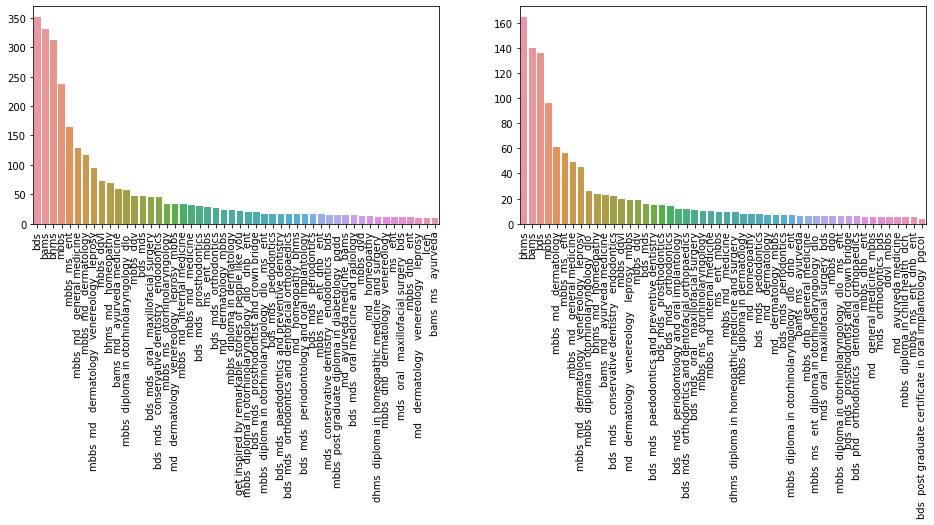

In [11]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

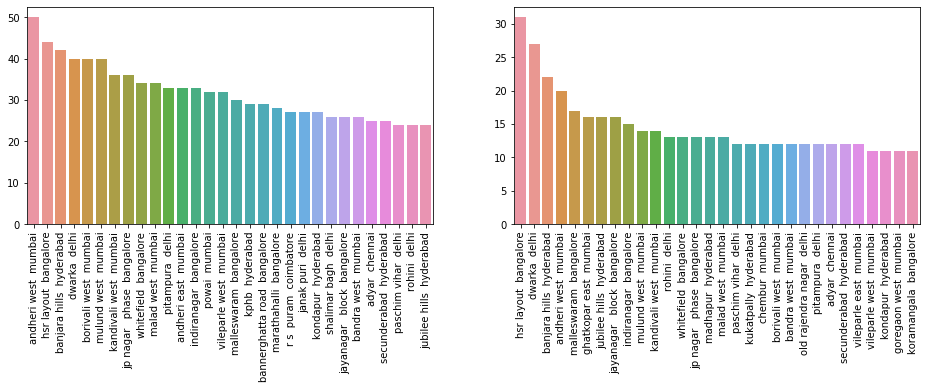

In [12]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

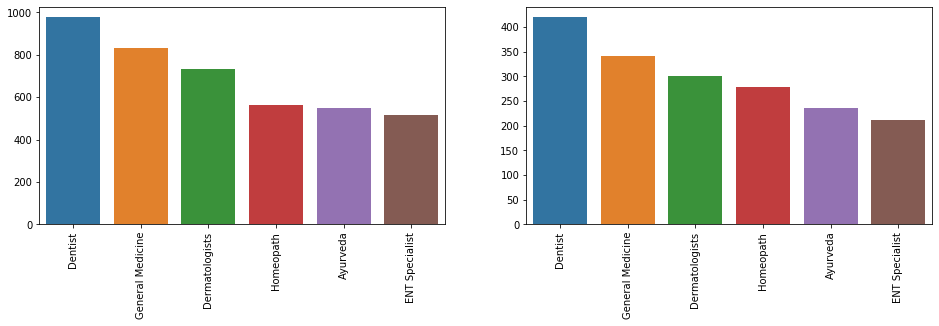

In [13]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [15]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [16]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [17]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no cnjunto de treino. Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [23]:
np.random.seed(1082141)
sns.set()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time 

In [19]:
# Parametros para hypertuning do modelo

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.0001, 0.01, 1, 10, 100]
epsilon = [0.1, 0.2, 0.6, 1, 2, 4]
parameters = [{'kernel':kernel,
                'C':C,
                'epsilon':epsilon}]
cv_folds = 5

In [21]:
start_time = time.time()
svr = GridSearchCV(SVR(), parameters, cv = cv_folds, scoring  = "neg_mean_absolute_error" , verbose=1, n_jobs=-1)
svr.fit(train_e, ye_train)
end_time = time.time()
print("total time {:.2f} seconds".format( end_time - start_time))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 19.7min finished


total time 1186.47 seconds


In [23]:
means = -1*svr.cv_results_['mean_test_score']
params = svr.cv_results_['params']
df_results = pd.concat([pd.DataFrame({'mean_test_score':means}), pd.DataFrame(params)], axis=1)


In [34]:
df_results

,mean_test_score,C,epsilon,kernel
0,0.805813,0.0001,0.1,linear
1,0.813360,0.0001,0.1,poly
2,0.812628,0.0001,0.1,rbf
3,0.812262,0.0001,0.1,sigmoid
4,0.808308,0.0001,0.2,linear
...,...,...,...,...
115,1870.575846,100.0000,2.0,sigmoid
116,1.150492,100.0000,4.0,linear
117,1.150492,100.0000,4.0,poly
118,1.150492,100.0000,4.0,rbf


In [36]:
def plot_vars(df=df_results, var_a='epsilon', var_b='C', figsize_i=(12,12)):
    fig, axs = plt.subplots(2, 2, figsize=figsize_i)

    fig.suptitle('Analise de {} vs {}'.format(var_a, var_b))

    df_data_l = df_results[df_results['kernel']=='linear'][['mean_test_score', var_a, var_b]].pivot(index='C', columns='epsilon', values='mean_test_score')
    df_data_p = df_results[df_results['kernel'] == 'poly'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_r = df_results[df_results['kernel'] == 'rbf'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    df_data_s = df_results[df_results['kernel'] == 'sigmoid'][['mean_test_score',var_a,var_b]].pivot(index = 'C', columns = 'epsilon', values = 'mean_test_score')
    sns.heatmap(ax = axs[0, 0], data = df_data_l, annot = True)
    axs[0, 0].set_title('Kernel - linear')

    sns.heatmap(ax = axs[0, 1], data =df_data_p, annot = True)
    axs[0, 1].set_title('Kernel - poly')

    sns.heatmap(ax = axs[1, 0], data =df_data_r, annot = True)
    axs[1, 0].set_title('Kernel - rbf')

    sns.heatmap(ax = axs[1, 1],data =df_data_s, annot = True)
    axs[1, 1].set_title('Kernel -sigmoid')

    plt.tight_layout()

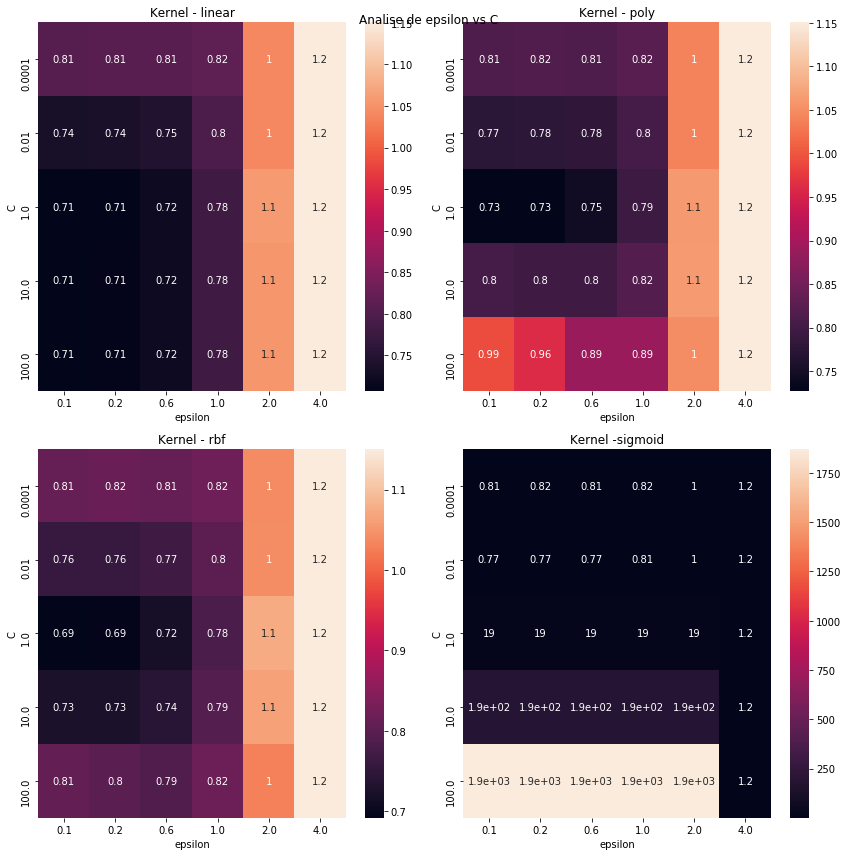

In [37]:
plot_vars(var_a = 'epsilon', var_b = 'C')

#### Avaliando melhor modelo de SVR com os melhores Hyperparametros

In [ ]:
# best_classifier = svm.SVR('BEST CLASSIFIER PARAMS HERE')
# best_classifier.fit(train_e, ye_train)
# test_prediction = best_classifier.predict(test_e)

# show_metrics(model=best_classifier, model_name='BEST CLASSIFIER NAME', prediction=test_prediction)

**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

#### Regressao Linear com o modelo Ridge

In [38]:
from sklearn.linear_model import Ridge

In [41]:
# Hyperparametros para tunning do modelo
model = Ridge()

solver = ['svd', 'cholesky', 'lsqr', 'sag']
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
fit_intercept = [True, False]
normalize = [False]

parameters = {'solver':solver,
                'alpha':alpha,
                'fit_intercept':fit_intercept,
                'normalize':normalize}
                
cv_folds = 5


In [44]:
find_ridge = GridSearchCV(estimator=model, 
                                cv=cv_folds,
                                param_grid=parameters, 
                                scoring="neg_mean_absolute_error", 
                                verbose=1, 
                                n_jobs=-1)

find_ridge.fit(train_e, ye_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    3.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False], 'normalize': [False],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)

In [45]:
means_ridge = -1*find_ridge.cv_results_['mean_test_score']
params_ridge = find_ridge.cv_results_['params']
df_results = pd.concat([pd.DataFrame({'mean_test_score':means_ridge}), pd.DataFrame(params_ridge)], axis=1)


In [52]:
mask = pd.notna(df_results['mean_test_score'])

df_results[mask].sort_values(by=['mean_test_score'])

,mean_test_score,alpha,fit_intercept,normalize,solver
46,0.719416,1.00000,False,False,lsqr
47,0.719511,1.00000,False,False,sag
43,0.719522,1.00000,True,False,sag
45,0.719739,1.00000,False,False,cholesky
38,0.720881,0.10000,False,False,lsqr
35,0.721086,0.10000,True,False,sag
39,0.721101,0.10000,False,False,sag
30,0.721158,0.01000,False,False,lsqr
22,0.721187,0.00100,False,False,lsqr
14,0.721190,0.00010,False,False,lsqr


## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [12]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

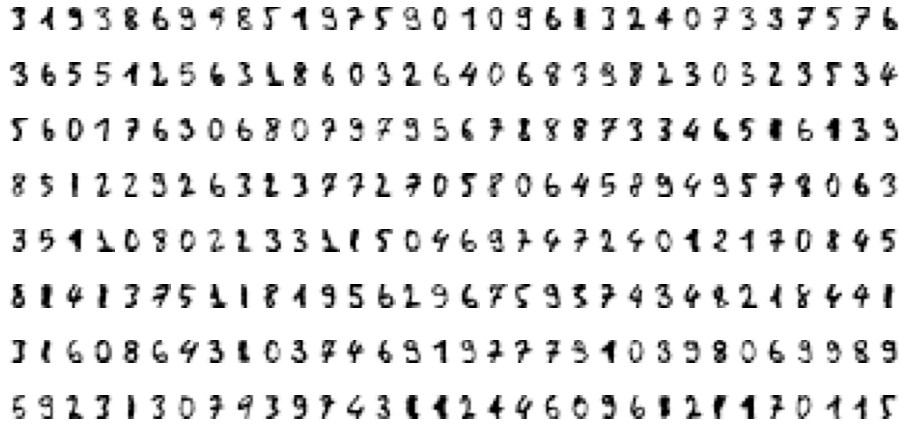

In [13]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

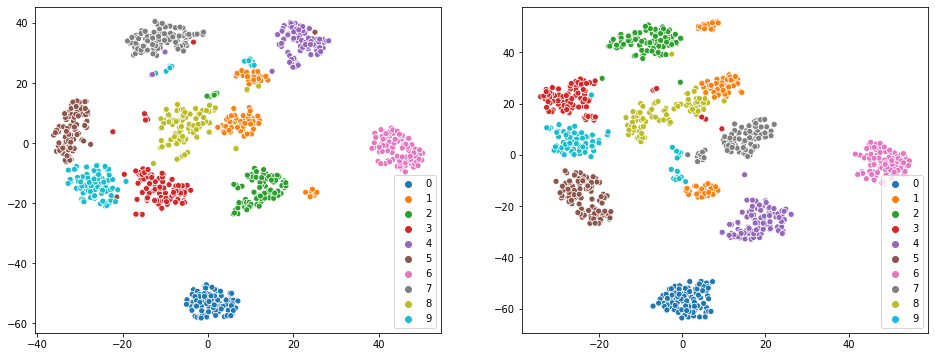

In [14]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

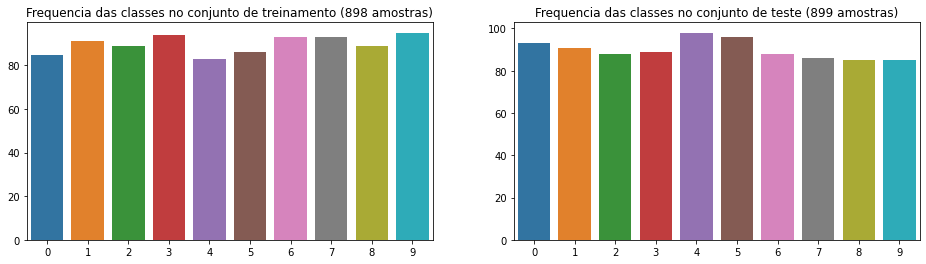

In [15]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.